In [1]:
import os
import numpy as np
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv

from load_data import get_adata
from utils import create_model_dir
from sc_condition_prediction import create_and_train_vae_model, validate_r2, evaluate_r2, N_INPUT, N_LAYERS, N_HIDDEN, N_LATENT, BATCH_SIZE

import warnings
warnings.filterwarnings('ignore')

# Initialize constants
load_dotenv()
CONDITION_KEY, CELL_TYPE_KEY, CONTROL_KEY, STIMULATED_KEY = os.getenv('CONDITION_KEY'), \
                                                            os.getenv('CELL_TYPE_KEY'), \
                                                            os.getenv("CONTROL_KEY"), \
                                                            os.getenv("STIMULATED_KEY")

# Load data
adata = get_adata(dataset="train_kang")

Global seed set to 0
/Users/danorel/Workspace/Education/University/Toronto/vaegen/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/danorel/Workspace/Education/University/Toronto/vaegen/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Control unit

In [2]:
USE_CUSTOM = True
VERBOSE = True

In [3]:
CELL_TYPE_TO_PREDICT = "CD4T"
CELL_TYPES_TO_VALIDATE = ["B", "FCGR3A+Mono", "CD14+Mono"]

### Cross-validation params

In [16]:
VALIDATION_SIZE = 200
ITERATIONS = 5
KFOLD = 10
EPOCHS = 15
THRESHOLD = 1000
STEP = 100

## Research unit

### Downsampling convergence strategy

In [17]:
create_model_dir("downsampling_test")

In [18]:
import numpy as np

from approaches.downsampling import get_downsampling_proportion
from utils import get_sample, remove_stimulated_for_cell_type

# table to store results
df_results = pd.DataFrame(data=np.zeros((ITERATIONS, 2)), 
                          index=np.arange(ITERATIONS), 
                          columns=['r2_test', "r2_validate"])

print(f'VAE model configuration: \n\tN_INPUT = {N_INPUT}\n\tN_HIDDEN = {N_HIDDEN}\n\tN_LAYERS = {N_LAYERS}\n\tN_LATENT = {N_LATENT}\n\tBATCH_SIZE = {BATCH_SIZE}')
print(f'Starting downsampling with a threshold of {THRESHOLD} instances for each of the cell types\n')

for iteration in range(ITERATIONS):
    print(f'{iteration}th step, threshold: {THRESHOLD} instances...')
    r2_test_iteration, r2_validate_iteration = 0, 0
    
    for fold in range(KFOLD):
        print(f'\n{fold}th fold...')

        index = iteration * (fold + 1)
        
        adata_validate = None
        for cell_type_to_validate in CELL_TYPES_TO_VALIDATE:
            adata_validate_cell_type = get_sample(adata, 
                                                  cell_type=cell_type_to_validate, 
                                                  sample_size=VALIDATION_SIZE)
            if adata_validate is None:
                adata_validate = adata_validate_cell_type
            else:
                adata_validate = ad.concat([adata_validate, adata_validate_cell_type])
            
        adata_train = adata[~(adata.obs.index.isin(adata_validate.obs.index)), :]
        
        adata_samples = get_downsampling_proportion(adata_train,
                                                    threshold=THRESHOLD,
                                                    verbose=VERBOSE)

        params_filename = os.path.join("models", "downsampling_test", f"{index}_autoencoder.pt")
        create_and_train_vae_model(adata_samples,
                                   epochs=EPOCHS,
                                   save_params_to_filename=params_filename,
                                   custom=USE_CUSTOM)
        params_filename = params_filename if USE_CUSTOM else os.path.join(params_filename, "model.pt")
        
        r2_test, _ = evaluate_r2(params_filename, adata_train, cell_type_to_predict=CELL_TYPE_TO_PREDICT)
        r2_validate, _ = validate_r2(params_filename, adata_validate, cell_types_to_predict=CELL_TYPES_TO_VALIDATE)
        
        r2_test_iteration += r2_test
        r2_validate_iteration += r2_validate
    
    df_results.loc[THRESHOLD, ['r2_test', "r2_validate"]] = [
        r2_test_iteration / KFOLD, 
        r2_validate_iteration / KFOLD
    ]
    
    # Step into lower sample threshold
    THRESHOLD -= STEP

VAE model configuration: 
	N_INPUT = 6998
	N_HIDDEN = 100
	N_LAYERS = 3
	N_LATENT = 10
	BATCH_SIZE = 32
Starting downsampling with a threshold of 1000 instances for each of the cell types

0th step, threshold: 1000 instances...

0th fold...
Dataset size before downsampling: 16322 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
Dendritic 615 | 615 0
CD4T 2437 | 1000 1437
B 735 | 735 0
FCGR3A+Mono 1035 | 1000 35
CD14+Mono 1800 | 1000 800
CD8T 574 | 574 0
---------- 
 stimulated
NK 646 | 646 0
Dendritic 463 | 463 0
CD4T 3127 | 1000 2127
B 889 | 889 0
FCGR3A+Mono 2372 | 1000 1372
CD14+Mono 571 | 571 0
CD8T 541 | 541 0
---------- Percentage distribution ----------
---------- 
 control
NK: 9.50%
Dendritic: 11.30%
CD4T: 18.38%
B: 13.51%
FCGR3A+Mono: 18.38%
CD14+Mono: 18.38%
CD8T: 10.55%
---------- 
 stimulated
NK: 12.64%
Dendritic: 9.06%
CD4T: 19.57%
B: 17.40%
FCGR3A+Mono: 19.57%
CD14+Mono: 11.17%
CD8T: 10.59%

Dataset size after downsampling: 1055

Dendritic 463 | 463 0
CD4T 3127 | 900 2227
B 891 | 891 0
FCGR3A+Mono 2365 | 900 1465
CD14+Mono 557 | 557 0
CD8T 541 | 541 0
---------- Percentage distribution ----------
---------- 
 control
NK: 10.05%
Dendritic: 11.96%
CD4T: 17.50%
B: 14.31%
FCGR3A+Mono: 17.50%
CD14+Mono: 17.50%
CD8T: 11.16%
---------- 
 stimulated
NK: 13.19%
Dendritic: 9.45%
CD4T: 18.37%
B: 18.19%
FCGR3A+Mono: 18.37%
CD14+Mono: 11.37%
CD8T: 11.05%

Dataset size after downsampling: 10040 cells

1th fold...
Dataset size before downsampling: 16322 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
Dendritic 615 | 615 0
CD4T 2437 | 900 1537
B 735 | 735 0
FCGR3A+Mono 1035 | 900 135
CD14+Mono 1800 | 900 900
CD8T 574 | 574 0
---------- 
 stimulated
NK 646 | 646 0
Dendritic 463 | 463 0
CD4T 3127 | 900 2227
B 889 | 889 0
FCGR3A+Mono 2372 | 900 1472
CD14+Mono 571 | 571 0
CD8T 541 | 541 0
---------- Percentage distribution ----------
---------- 
 control
NK: 10.06%
Dendritic: 11.96%
CD4


1th fold...
Dataset size before downsampling: 16320 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
Dendritic 615 | 615 0
CD4T 2437 | 800 1637
B 736 | 736 0
FCGR3A+Mono 1040 | 800 240
CD14+Mono 1811 | 800 1011
CD8T 574 | 574 0
---------- 
 stimulated
NK 646 | 646 0
Dendritic 463 | 463 0
CD4T 3127 | 800 2327
B 891 | 800 91
FCGR3A+Mono 2365 | 800 1565
CD14+Mono 557 | 557 0
CD8T 541 | 541 0
---------- Percentage distribution ----------
---------- 
 control
NK: 10.68%
Dendritic: 12.70%
CD4T: 16.52%
B: 15.20%
FCGR3A+Mono: 16.52%
CD14+Mono: 16.52%
CD8T: 11.85%
---------- 
 stimulated
NK: 14.02%
Dendritic: 10.05%
CD4T: 17.36%
B: 17.36%
FCGR3A+Mono: 17.36%
CD14+Mono: 12.09%
CD8T: 11.74%

Dataset size after downsampling: 9449 cells

2th fold...
Dataset size before downsampling: 16322 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
Dendritic 615 | 615 0
CD4T 2437 | 800 1637
B 735 | 735 0
FCGR3A+Mono 1035 |


2th fold...
Dataset size before downsampling: 16320 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
Dendritic 615 | 615 0
CD4T 2437 | 700 1737
B 736 | 700 36
FCGR3A+Mono 1040 | 700 340
CD14+Mono 1811 | 700 1111
CD8T 574 | 574 0
---------- 
 stimulated
NK 646 | 646 0
Dendritic 463 | 463 0
CD4T 3127 | 700 2427
B 891 | 700 191
FCGR3A+Mono 2365 | 700 1665
CD14+Mono 557 | 557 0
CD8T 541 | 541 0
---------- Percentage distribution ----------
---------- 
 control
NK: 11.47%
Dendritic: 13.65%
CD4T: 15.53%
B: 15.53%
FCGR3A+Mono: 15.53%
CD14+Mono: 15.53%
CD8T: 12.74%
---------- 
 stimulated
NK: 15.00%
Dendritic: 10.75%
CD4T: 16.25%
B: 16.25%
FCGR3A+Mono: 16.25%
CD14+Mono: 12.93%
CD8T: 12.56%

Dataset size after downsampling: 8813 cells

3th fold...
Dataset size before downsampling: 16322 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
Dendritic 615 | 615 0
CD4T 2437 | 700 1737
B 735 | 700 35
FCGR3A+Mono 103


3th fold...
Dataset size before downsampling: 16320 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
Dendritic 615 | 600 15
CD4T 2437 | 600 1837
B 736 | 600 136
FCGR3A+Mono 1040 | 600 440
CD14+Mono 1811 | 600 1211
CD8T 574 | 574 0
---------- 
 stimulated
NK 646 | 600 46
Dendritic 463 | 463 0
CD4T 3127 | 600 2527
B 891 | 600 291
FCGR3A+Mono 2365 | 600 1765
CD14+Mono 557 | 557 0
CD8T 541 | 541 0
---------- Percentage distribution ----------
---------- 
 control
NK: 12.64%
Dendritic: 14.67%
CD4T: 14.67%
B: 14.67%
FCGR3A+Mono: 14.67%
CD14+Mono: 14.67%
CD8T: 14.03%
---------- 
 stimulated
NK: 15.15%
Dendritic: 11.69%
CD4T: 15.15%
B: 15.15%
FCGR3A+Mono: 15.15%
CD14+Mono: 14.06%
CD8T: 13.66%

Dataset size after downsampling: 8052 cells

4th fold...
Dataset size before downsampling: 16322 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
Dendritic 615 | 600 15
CD4T 2437 | 600 1837
B 735 | 600 135
FCGR3A+Mon

Text(0, 0.5, '$R^2$')

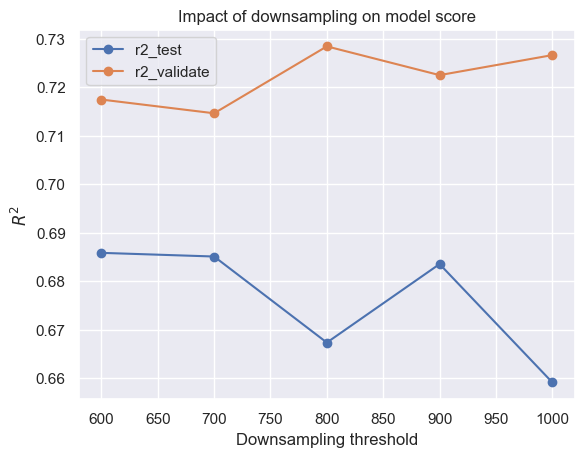

In [22]:
df_results.plot(y=['r2_test', 'r2_validate'], marker='o')
plt.title('Impact of downsampling on model score')
plt.xlabel('Downsampling threshold')
plt.ylabel('$R^2$')

### Downsampling minimum strategy

In [8]:
create_model_dir("downsampling_minimum_test")

In [9]:
from downsampling import get_downsampling_minimum

r2_test_kfold = 0
r2_validate_kfold = 0

for fold in range(KFOLD):
    print(f'\n{fold}th fold...')
        
    adata_validate = None
    for cell_type_to_validate in CELL_TYPES_TO_VALIDATE:
        adata_validate_cell_type = get_sample(adata, 
                                              cell_type=cell_type_to_validate, 
                                              sample_size=VALIDATION_SIZE)
        if adata_validate is None:
            adata_validate = adata_validate_cell_type
        else:
            adata_validate = ad.concat([adata_validate, adata_validate_cell_type])
            
    adata_train = adata[~(adata.obs.index.isin(adata_validate.obs.index)), :]
        
    adata_sample = get_downsampling_minimum(adata_train,
                                            verbose=VERBOSE)

    params_filename = os.path.join("models", "downsampling_minimum_test", f"autoencoder.pt")
    create_and_train_vae_model(adata_sample,
                               epochs=EPOCHS,
                               save_params_to_filename=params_filename,
                               custom=USE_CUSTOM)
    params_filename = params_filename if USE_CUSTOM else os.path.join(params_filename, "model.pt")
    
    r2_test, _ = evaluate_r2(params_filename, adata_train, cell_type_to_predict=CELL_TYPE_TO_PREDICT)
    r2_validate, _ = validate_r2(params_filename, adata_validate, cell_types_to_predict=CELL_TYPES_TO_VALIDATE)
    
    r2_test_kfold += r2_test
    r2_validate_kfold += r2_validate
        
r2_test_downsampled = r2_test_kfold / KFOLD
r2_validate_downsampled = r2_validate_kfold / KFOLD
    
print("\n")
print(f"R*2 test downsampled: {r2_test_downsampled:.2f}")
print(f"R*2 validate downsampled: {r2_validate_downsampled:.2f}")


0th fold...
Minimum cell type Dendritic with size: 463
Excluding None cell type from dataset for downsampling...
Dataset size before downsampling: 16318 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 463 54
Dendritic 615 | 463 152
CD4T 2437 | 463 1974
B 736 | 463 273
FCGR3A+Mono 1039 | 463 576
CD14+Mono 1809 | 463 1346
CD8T 574 | 463 111
---------- 
 stimulated
NK 646 | 463 183
Dendritic 463 | 463 0
CD4T 3127 | 463 2664
B 887 | 463 424
FCGR3A+Mono 2367 | 463 1904
CD14+Mono 560 | 463 97
CD8T 541 | 463 78
---------- Percentage distribution ----------
---------- 
 control
NK: 14.29%
Dendritic: 14.29%
CD4T: 14.29%
B: 14.29%
FCGR3A+Mono: 14.29%
CD14+Mono: 14.29%
CD8T: 14.29%
---------- 
 stimulated
NK: 14.29%
Dendritic: 14.29%
CD4T: 14.29%
B: 14.29%
FCGR3A+Mono: 14.29%
CD14+Mono: 14.29%
CD8T: 14.29%

Dataset size after downsampling: 6482 cells

1th fold...
Minimum cell type Dendritic with size: 463
Excluding None cell type from dataset for downsampli



R*2 test downsampled: 0.70
R*2 validate downsampled: 0.73


### Downsampling leave-one-out strategy

In [10]:
create_model_dir("downsampling_leave-one-out_test")

In [11]:
from downsampling import get_downsampling_minimum
from utils import remove_cell_type, get_sample

exclude_cell_types = ["CD14+Mono", "B", "CD8T", "NK", "FCGR3A+Mono", "Dendritic"]

df_results = pd.DataFrame(data=np.zeros((len(exclude_cell_types), 2)), 
                          index=exclude_cell_types, 
                          columns=['r2_test', 'r2_validate'])

for exclude_cell_type in exclude_cell_types:
    r2_test_kfold = 0
    r2_validate_kfold = 0

    for fold in range(KFOLD):
        print(f'\n{fold}th fold...')
        
        adata_validate = None
        for cell_type_to_validate in CELL_TYPES_TO_VALIDATE:
            adata_validate_cell_type = get_sample(adata, 
                                                  cell_type=cell_type_to_validate, 
                                                  sample_size=VALIDATION_SIZE)
            if adata_validate is None:
                adata_validate = adata_validate_cell_type
            else:
                adata_validate = ad.concat([adata_validate, adata_validate_cell_type])
                
        adata_no_cell_type = remove_cell_type(adata, cell_type=exclude_cell_type)
            
        adata_train = adata_no_cell_type[~(adata_no_cell_type.obs.index.isin(adata_validate.obs.index)), :]
        
        adata_sample = get_downsampling_minimum(adata_train,
                                                exclude_cell_type=exclude_cell_type,
                                                verbose=VERBOSE)

        params_filename = os.path.join("models", "downsampling_leave-one-out_test", f"{exclude_cell_type}_autoencoder.pt")
        create_and_train_vae_model(adata_sample,
                                   epochs=EPOCHS,
                                   save_params_to_filename=params_filename,
                                   custom=USE_CUSTOM)
        params_filename = params_filename if USE_CUSTOM else os.path.join(params_filename, "model.pt")
    
        r2_test, _ = evaluate_r2(params_filename, adata_train, cell_type_to_predict=CELL_TYPE_TO_PREDICT)
        r2_validate, _ = validate_r2(params_filename, adata_validate, cell_types_to_predict=CELL_TYPES_TO_VALIDATE)

        r2_test_kfold += r2_test
        r2_validate_kfold += r2_validate
    
    r2_test_cell_type = r2_test_kfold / KFOLD
    r2_validate_cell_type = r2_validate_kfold / KFOLD
    
    print("\n")
    print(f"R*2 test with {exclude_cell_type} excluded: {r2_test_cell_type:.2f}")
    print(f"R*2 validate with {exclude_cell_type} excluded: {r2_validate_cell_type:.2f}")
    
    df_results.loc[exclude_cell_type, ['r2_test', 'r2_validate']] = [r2_test_cell_type, r2_validate_cell_type]


0th fold...
Minimum cell type Dendritic with size: 463
Excluding CD14+Mono cell type from dataset for downsampling...
Dataset size before downsampling: 13951 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 463 54
Dendritic 615 | 463 152
CD4T 2437 | 463 1974
B 735 | 463 272
FCGR3A+Mono 1035 | 463 572
CD8T 574 | 463 111
---------- 
 stimulated
NK 646 | 463 183
Dendritic 463 | 463 0
CD4T 3127 | 463 2664
B 889 | 463 426
FCGR3A+Mono 2372 | 463 1909
CD8T 541 | 463 78
---------- Percentage distribution ----------
---------- 
 control
NK: 16.67%
Dendritic: 16.67%
CD4T: 16.67%
B: 16.67%
FCGR3A+Mono: 16.67%
CD8T: 16.67%
---------- 
 stimulated
NK: 16.67%
Dendritic: 16.67%
CD4T: 16.67%
B: 16.67%
FCGR3A+Mono: 16.67%
CD8T: 16.67%

Dataset size after downsampling: 5556 cells

1th fold...
Minimum cell type Dendritic with size: 463
Excluding CD14+Mono cell type from dataset for downsampling...
Dataset size before downsampling: 13953 cells


---------- Select/Rem

Minimum cell type Dendritic with size: 463
Excluding B cell type from dataset for downsampling...
Dataset size before downsampling: 14702 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 463 54
Dendritic 615 | 463 152
CD4T 2437 | 463 1974
FCGR3A+Mono 1035 | 463 572
CD14+Mono 1814 | 463 1351
CD8T 574 | 463 111
---------- 
 stimulated
NK 646 | 463 183
Dendritic 463 | 463 0
CD4T 3127 | 463 2664
FCGR3A+Mono 2373 | 463 1910
CD14+Mono 560 | 463 97
CD8T 541 | 463 78
---------- Percentage distribution ----------
---------- 
 control
NK: 16.67%
Dendritic: 16.67%
CD4T: 16.67%
FCGR3A+Mono: 16.67%
CD14+Mono: 16.67%
CD8T: 16.67%
---------- 
 stimulated
NK: 16.67%
Dendritic: 16.67%
CD4T: 16.67%
FCGR3A+Mono: 16.67%
CD14+Mono: 16.67%
CD8T: 16.67%

Dataset size after downsampling: 5556 cells

1th fold...
Minimum cell type Dendritic with size: 463
Excluding B cell type from dataset for downsampling...
Dataset size before downsampling: 14696 cells


---------- Select



R*2 test with B excluded: 0.68
R*2 validate with B excluded: 0.74

0th fold...
Minimum cell type Dendritic with size: 463
Excluding CD8T cell type from dataset for downsampling...
Dataset size before downsampling: 15195 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 463 54
Dendritic 615 | 463 152
CD4T 2437 | 463 1974
B 728 | 463 265
FCGR3A+Mono 1038 | 463 575
CD14+Mono 1799 | 463 1336
---------- 
 stimulated
NK 646 | 463 183
Dendritic 463 | 463 0
CD4T 3127 | 463 2664
B 891 | 463 428
FCGR3A+Mono 2369 | 463 1906
CD14+Mono 565 | 463 102
---------- Percentage distribution ----------
---------- 
 control
NK: 16.67%
Dendritic: 16.67%
CD4T: 16.67%
B: 16.67%
FCGR3A+Mono: 16.67%
CD14+Mono: 16.67%
---------- 
 stimulated
NK: 16.67%
Dendritic: 16.67%
CD4T: 16.67%
B: 16.67%
FCGR3A+Mono: 16.67%
CD14+Mono: 16.67%

Dataset size after downsampling: 5556 cells

1th fold...
Minimum cell type Dendritic with size: 463
Excluding CD8T cell type from dataset for down



R*2 test with CD8T excluded: 0.67
R*2 validate with CD8T excluded: 0.75

0th fold...
Minimum cell type Dendritic with size: 463
Excluding NK cell type from dataset for downsampling...
Dataset size before downsampling: 15156 cells


---------- Select/Remove distribution ----------
---------- 
 control
Dendritic 615 | 463 152
CD4T 2437 | 463 1974
B 735 | 463 272
FCGR3A+Mono 1034 | 463 571
CD14+Mono 1801 | 463 1338
CD8T 574 | 463 111
---------- 
 stimulated
Dendritic 463 | 463 0
CD4T 3127 | 463 2664
B 883 | 463 420
FCGR3A+Mono 2372 | 463 1909
CD14+Mono 574 | 463 111
CD8T 541 | 463 78
---------- Percentage distribution ----------
---------- 
 control
Dendritic: 16.67%
CD4T: 16.67%
B: 16.67%
FCGR3A+Mono: 16.67%
CD14+Mono: 16.67%
CD8T: 16.67%
---------- 
 stimulated
Dendritic: 16.67%
CD4T: 16.67%
B: 16.67%
FCGR3A+Mono: 16.67%
CD14+Mono: 16.67%
CD8T: 16.67%

Dataset size after downsampling: 5556 cells

1th fold...
Minimum cell type Dendritic with size: 463
Excluding NK cell type from datase



R*2 test with NK excluded: 0.64
R*2 validate with NK excluded: 0.74

0th fold...
Minimum cell type Dendritic with size: 463
Excluding FCGR3A+Mono cell type from dataset for downsampling...
Dataset size before downsampling: 12911 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 463 54
Dendritic 615 | 463 152
CD4T 2437 | 463 1974
B 726 | 463 263
CD14+Mono 1810 | 463 1347
CD8T 574 | 463 111
---------- 
 stimulated
NK 646 | 463 183
Dendritic 463 | 463 0
CD4T 3127 | 463 2664
B 895 | 463 432
CD14+Mono 560 | 463 97
CD8T 541 | 463 78
---------- Percentage distribution ----------
---------- 
 control
NK: 16.67%
Dendritic: 16.67%
CD4T: 16.67%
B: 16.67%
CD14+Mono: 16.67%
CD8T: 16.67%
---------- 
 stimulated
NK: 16.67%
Dendritic: 16.67%
CD4T: 16.67%
B: 16.67%
CD14+Mono: 16.67%
CD8T: 16.67%

Dataset size after downsampling: 5556 cells

1th fold...
Minimum cell type Dendritic with size: 463
Excluding FCGR3A+Mono cell type from dataset for downsampling...
Datas

Minimum cell type NK with size: 517
Excluding Dendritic cell type from dataset for downsampling...
Dataset size before downsampling: 15244 cells


---------- Select/Remove distribution ----------
---------- 
 control
NK 517 | 517 0
CD4T 2437 | 517 1920
B 737 | 517 220
FCGR3A+Mono 1034 | 517 517
CD14+Mono 1796 | 517 1279
CD8T 574 | 517 57
---------- 
 stimulated
NK 646 | 517 129
CD4T 3127 | 517 2610
B 890 | 517 373
FCGR3A+Mono 2372 | 517 1855
CD14+Mono 573 | 517 56
CD8T 541 | 517 24
---------- Percentage distribution ----------
---------- 
 control
NK: 16.67%
CD4T: 16.67%
B: 16.67%
FCGR3A+Mono: 16.67%
CD14+Mono: 16.67%
CD8T: 16.67%
---------- 
 stimulated
NK: 16.67%
CD4T: 16.67%
B: 16.67%
FCGR3A+Mono: 16.67%
CD14+Mono: 16.67%
CD8T: 16.67%

Dataset size after downsampling: 6204 cells

1th fold...
Minimum cell type NK with size: 517
Excluding Dendritic cell type from dataset for downsampling...
Dataset size before downsampling: 15246 cells


---------- Select/Remove distribution ---------

Text(0, 0.5, '$R^2$')

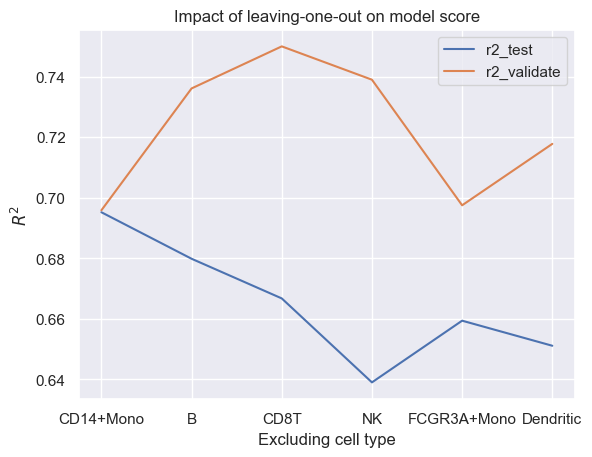

In [12]:
df_results.plot(y=['r2_test', 'r2_validate'], kind='line')
plt.title('Impact of leaving-one-out on model score')
plt.xlabel('Excluding cell type')
plt.ylabel('$R^2$')